Sending request... Endpoint :  http://bc1bc164-6c84-4560-ae8a-0f2ec9ec7dc6.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


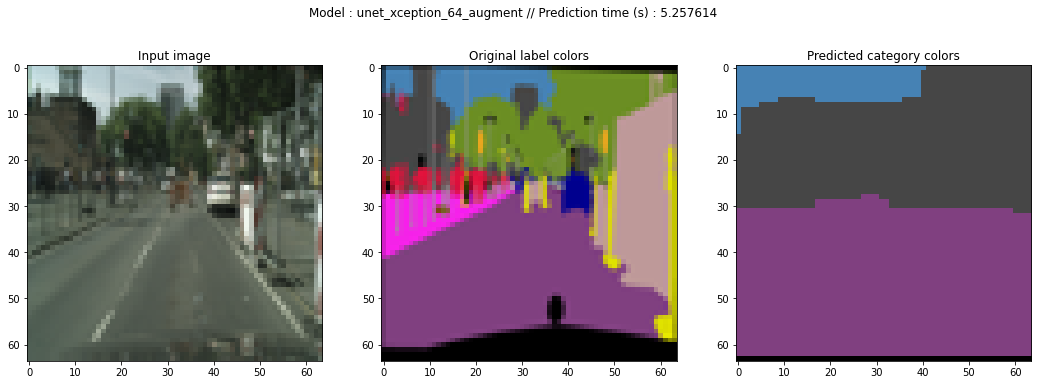

Sending request... Endpoint :  http://332d8e0d-9b4a-4655-8643-2bc53943360d.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


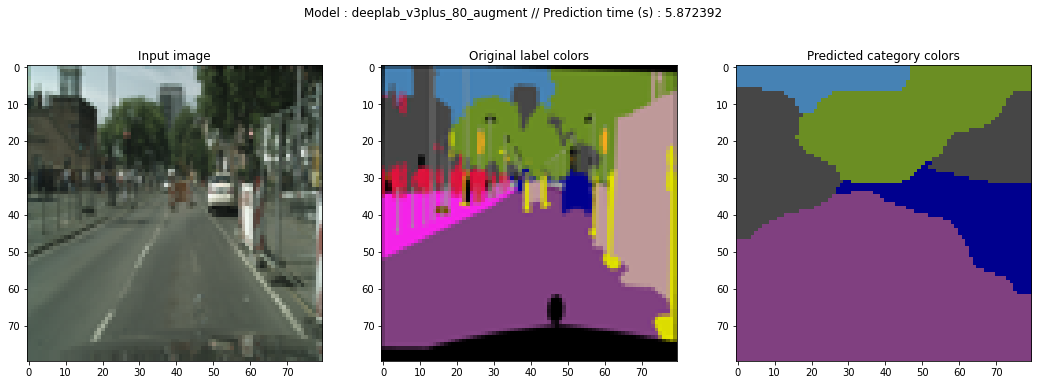

Sending request... Endpoint :  http://08f06ab5-e92c-49de-b297-4ef971693ae4.westeurope.azurecontainer.io/score
Response recieved... Status code :  502


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fececf81810>

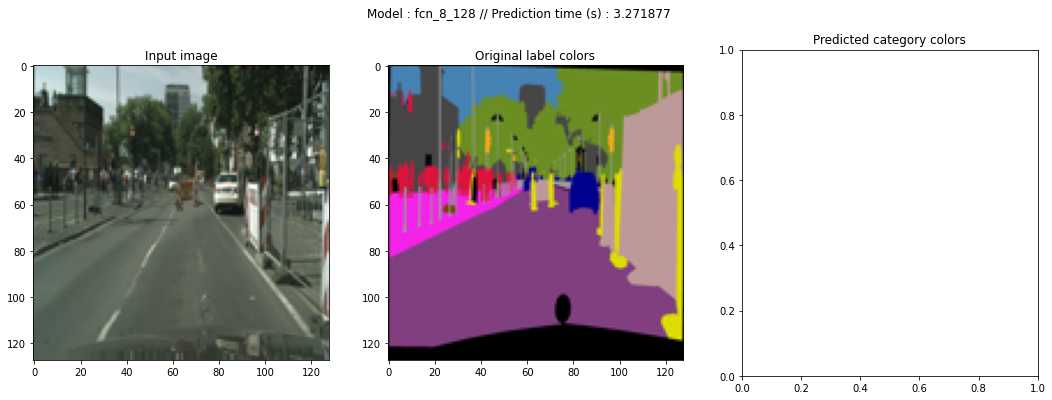

In [2]:
import base64
import json
from io import BytesIO
from pathlib import Path

import numpy as np
import requests
from dotenv import dotenv_values
from matplotlib import pyplot as plt
from PIL import Image

# Get the model
model_names = [
    "unet_xception_64_augment",
    "deeplab_v3plus_80_augment",
    "fcn_8_128",
    "unet_xception_128",
    "deeplab_v3plus_128",
    "deeplab_v3plus_160",
    "fcn_8_256",
    "unet_xception_256_augment",
    "unet_xception_256",
    "deeplab_v3plus_256",
    "deeplab_v3plus_320_augment",
    "fcn_8_512",
    "unet_xception_512",
    "deeplab_v3plus_512",
    "deeplab_v3plus_640",
]


# Get the images
raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)

# Get a random image index
rand_idx = np.random.randint(0, len(val_input_img_paths))


with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")

    # Request data goes here
    data = {"image": im_b64_str}
    payload = str.encode(json.dumps(data))

    for model_name in model_names:
        # Set the model input size
        model_input_size = int(
            model_name.replace("_augment", "").split("_")[-1]
        )
        img_size = (model_input_size, model_input_size)

        # Call the inference endpoint
        inference_config = dotenv_values(Path(f"../.env.{model_name}"))
        url = inference_config["AZURE_INFERENCE_ENDPOINT"]
        headers = {
            "Content-Type": "application/json",
            "Authorization": (
                "Bearer " + inference_config["AZURE_INFERENCE_KEY"]
            ),
        }

        print("Sending request... Endpoint : ", url)
        r = requests.post(url, headers=headers, data=payload)
        print("Response recieved... Status code : ", r.status_code)
        result = r.content
        time = r.elapsed.total_seconds()

        # Plot the image, ground truth and prediction
        fig, ax = plt.subplots(
            nrows=1,
            ncols=3,
            figsize=(18, 6),
        )
        fig.suptitle(f"Model : {model_name} // Prediction time (s) : {time}")

        ax[0].title.set_text("Input image")
        val_img = Image.open(val_input_img_paths[rand_idx]).resize(img_size)
        ax[0].imshow(val_img)

        ax[1].title.set_text("Original label colors")
        val_colors = Image.open(val_label_colors_img_paths[rand_idx]).resize(
            img_size
        )
        ax[1].imshow(val_colors)

        ax[2].title.set_text("Predicted category colors")
        ax[2].imshow(Image.open(BytesIO(base64.b64decode(result))))

        plt.show()
